In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/RunRespMonitoringOnHDF5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
'''
import basic packages
'''
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
'''
import packages from local files
'''
from HDF5_methods import unpackHDF5
from HDF5_methods import getAllLabels
from HDF5_methods import unpackMyHDF5File

from ROI_Detection.ManualUNET import hd_dt
from ROI_Detection.ManualUNET import conv2d_block
from ROI_Detection.ManualUNET import get_unet

from ROI_Detection.AutomaticUNET import UNET
from ROI_Detection.AutomaticUNET import processOuput
from ROI_Detection.AutomaticUNET import callAutomaticUNET

from Resp_Calculation.RespRateCalculator_methods import calc_rep
from Resp_Calculation.RespRateCalculator_methods import calcLenght

from Resp_Calculation.RespRate_methods import calcRates_with_findLocalMaximas
from Resp_Calculation.RespRate_methods import calcRates_with_calcRate
from Resp_Calculation.RespRate_methods import calcRates_with_FFT
from Resp_Calculation.RespRate_methods import calcRates_with_findLocalMaximas_and_MA
from Resp_Calculation.RespRate_methods import calcRates_with_calcRate_and_MA
from Resp_Calculation.RespRate_methods import calcRates_with_FFT_and_MA
from Resp_Calculation.RespRate_methods import RMSE
from Resp_Calculation.RespRate_methods import reshapeSignal
from Resp_Calculation.RespRate_methods import reshapeReference

# Parameters

In [ ]:
'''
Set basic parameters
'''
FILENAME = '../Measurements/Meas4.hdf5'
wh = 150 # width-height: The size of image which size we will resize images to (wh x wh)
ws = 200 # length or Size of the sliding-Window
FPS = 20 # Sampling frequency of the camera
im_width = 500 # initial image-width for manual-unet
im_height = 500 # initial image-height for manual-unet
downscale_coeff = 2 
length_of_win_of_frames = 200 # The length of the sliding window, we are using in the calculatio of respiration rates. (This length is the same as the one that is used by the Philips IntelliVue MP20/MP50 monitors that provided the reference data for us.)

'''
ROI detector related parameters
'''
# how many frames, two ROI-calculation are apart from each other
UNET_usage_frequency = 100

# Bolean: use the "UNET based roi detector" or not
use_roi_detector = True

# Boolean: Use the manual unet or the ALA based one
use_manual = True

# Load HDF5


In [ ]:
# unpack frames, labels and results from hdf5
frames, labels = unpackMyHDF5File(FILENAME)
# unpack labels, the numerical labels more exactly the respiration rates
RespirationNumerical = labels[5]

In [ ]:
# check the length of parts of my dataset
print(len(frames))
print(len(RespirationNumerical))

In [ ]:
'''
Check the first frame
'''
frame = frames[0]
plt.imshow((frame).astype('uint8'))

# Define ManualUNET

In [ ]:
# get the manual unet
from keras.layers import Input
input_img = Input((int(im_height/downscale_coeff), int(im_width/downscale_coeff), 3), name='img')
model = get_unet(input_img, n_filters=int(15), dropout=0.00, batchnorm=True)

In [ ]:
# load parameters
model_name = '../lhs_model14.h5'
model.load_weights(model_name)

# Try to run ManualUNET

In [ ]:
def callManualUNET(img):
  img = cv2.resize(img,(250,250))
  batch = [np.cast['float32']((img/np.max(img)))]
  batch = np.asarray(batch)

  im = np.reshape(batch,[1,250,250,3])
  preds_im = model.predict(im, verbose=1)
  predicted = preds_im[0,:,:,0]
  preds_im = cv2.resize(predicted,(wh,wh))
  return preds_im

In [ ]:
img = frames[0]
preds_im = callManualUNET(img)
plt.imshow(preds_im)

# Define AutomaticUNET

In [ ]:
dev = torch.device("cuda:0")

In [ ]:
net = UNET(3,3).to(dev)

In [ ]:
net.load_state_dict(torch.load("../checkpoints/autoAnnotation1_150x150_4_mely_nagyobb_kernelek-UNET_version-0073.pth"))

# Try to run AutomaticUNET

In [ ]:
img = frames[0]
processed_mask = callAutomaticUNET(img,wh,net,dev)

In [ ]:
plt.imshow(processed_mask)
plt.colorbar()

In [ ]:
img = np.cast['float32']((img/np.max(img)))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (wh,wh))

img[:,:,0]=img[:,:,0]*processed_mask
img[:,:,1]=img[:,:,1]*processed_mask
img[:,:,2]=img[:,:,2]*processed_mask
plt.imshow(img)

# Initialization the parameters for the iterative running of respiration calculation

In [ ]:
szamlalo = 0
frame = frames[szamlalo]
if use_manual:
  roi = callManualUNET(img)
else:
  roi = callAutomaticUNET(frame)
kernel = np.ones((5,5),np.uint8)
first_frame = frames[szamlalo]
first_frame = cv2.resize(first_frame, dsize=(wh,wh), interpolation=cv2.INTER_CUBIC)
first_frame = np.cast['float32']((first_frame/np.max(first_frame)))
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(first_frame,(21,21),0)
prvs = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)
grad_prvs = cv2.morphologyEx(prvs, cv2.MORPH_GRADIENT, kernel)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255
hsv = np.zeros_like(first_frame)
hsv[...,1] = 255
datapoint = 0
datapoint2 = 0
unet_szamlalo = 0
RespirationNumerical[1:]

# Iterate over frames

In [ ]:
sliding_window_frames = []

In [ ]:
with open("outputs/resp_wave/wave_with_unet0.txt","w") as o:
  for i in range(len(frames)-1):
    frame = frames[i]

    if use_roi_detector:
      # Calculate ROI (right after the frame selection)
      if unet_szamlalo % UNET_usage_frequency==0:
        roi = callAutomaticUNET(frame,wh,net,dev)

    frame = cv2.resize(frame, dsize=(wh,wh), interpolation=cv2.INTER_CUBIC)
    frame = np.cast['float32']((frame/np.max(frame)))

    if use_roi_detector:
      if frame is not None: 
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        flow[:,:,0] = flow[:,:,0]*roi
        flow[:,:,1] = flow[:,:,1]*roi
        datapoint = calc_rep(flow) / sum(roi.flatten())
        datapoint2 = calcLenght(flow) / sum(roi.flatten())
        ref = RespirationNumerical[szamlalo]
        o.write(str(datapoint) + " , " + str(datapoint2) + " , " + str(ref[0]) + "\n")
    else:
      if frame is not None: 
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        flow[:,:,0] = flow[:,:,0]
        flow[:,:,1] = flow[:,:,1]
        datapoint = calc_rep(flow)
        datapoint2 = calcLenght(flow)
        ref = RespirationNumerical[szamlalo]
        print(szamlalo)
        o.write(str(datapoint) + " , " + str(datapoint2) + " , " + str(ref[0]) + "\n")


    if (length_of_win_of_frames<len(sliding_window_frames)):
        del sliding_window_frames[0]
    sliding_window_frames.append(datapoint)

    
    unet_szamlalo = unet_szamlalo + 1
    szamlalo = szamlalo + 1 

# Load the calculated Resp Wave

In [ ]:
# load the content of wave_with_unet0.txt generated previously 
resp_sig = np.loadtxt("outputs/resp_wave/wave_with_unet0.txt",delimiter=",")
resp_sig = np.asarray(resp_sig)
print(resp_sig.shape)

In [ ]:
# read the wave-like respiration signal
signal = resp_sig[:,0]
print(signal.shape)

In [ ]:
# read the referene signal (respiration rates)
refflow = resp_sig[:,-1]
print(refflow.shape)

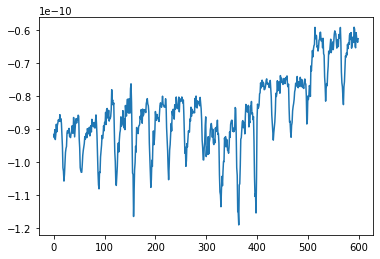

In [ ]:
# let's see an arbitrary part of the signal
plt.plot(signal[4000:4600])

# Apply BandPassFilter on input signal

In [ ]:
fs = 20.0 # sample rate

# desired cutoff frequencies (in Hz):
lowcut = 0.3
highcut = 2

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
filtered = butter_bandpass_filter(signal, lowcut, highcut, fs, order=6)

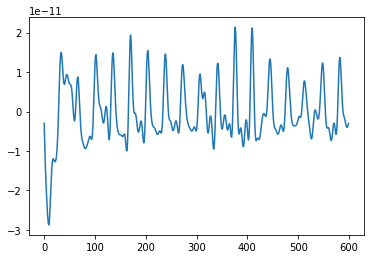

In [ ]:
# let's see an arbitrary part of the signal after the band-pass filtering
plt.plot(filtered[4000:4600])

# Reshape signals to [wd,wd]

In [ ]:
optsignal = reshapeSignal(filtered)

In [ ]:
reference = reshapeReference(refflow)

# Calculate Resp Rates

In [ ]:
# Calc RespRates by findLocalMaximas
diffRate_rates,refs = calcRates_with_findLocalMaximas(optsignal,reference)

In [ ]:
errors = []
for i in range(len(diffRate_rates)):
  errors.append(abs(diffRate_rates[i]-refs[i]))
print(np.mean(errors))
print(RMSE(diffRate_rates,refs))

2.589433674448948
3.8255518057140754


# Calculate Resp Rates With MA

In [ ]:
optsignal = reshapeSignal(filtered)

In [ ]:
reference = reshapeReference(refflow)

In [ ]:
output_rates,refs = calcRates_with_findLocalMaximas_and_MA(optsignal,reference)

In [ ]:
errors = []
for i in range(len(output_rates)):
  errors.append(abs(output_rates[i]-refs[i]))
print("Mean Absolute Error (MAE): " + "\t" + str(np.mean(errors)) + "\t" + " RPM")
print("Root Mean Squared Error (MAE): " + "\t" + str(RMSE(output_rates,refs)) + "\t" + " RPM")

Mean Absolute Error (MAE): 	1.3314741552531515	 RPM
Root Mean Squared Error (MAE): 	1.617265588866917	 RPM
